# Analyzing the Mental Health of International Students

### *Author:* Grady Cooke
### *Date:* June 10, 2025

## Summary

In 2018, a Japanese international university surveyed its student population, and the findings—published the following year with approval from various ethical and regulatory boards—highlighted elevated mental health risks among international students. The study found that social connectedness and acculturative stress were key predictors of depression. In this analysis, I focus on international students specifically and use SQL to explore how their mental health scores relate to the length of stay, aiming to assess whether duration of stay might influence depression, social connectedness, and acculturative stress outcomes.

| Field Name    | Description                                      |
| ------------- | ------------------------------------------------ |
| `inter_dom`     | Types of students (international or domestic)   |
| `japanese_cate` | Japanese language proficiency                    |
| `english_cate`  | English language proficiency                     |
| `academic`      | Current academic level (undergraduate or graduate) |
| `age`           | Current age of student                           |
| `stay`          | Current length of stay in years                  |
| `todep`         | Total score of depression (PHQ-9 test)           |
| `tosc`          | Total score of social connectedness (SCS test)   |
| `toas`          | Total score of acculturative stress (ASISS test) |

In [4]:
# Import required packages
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Load your CSV file
students = pd.read_csv("students.csv")

# Create SQLite connection (file-based is portable)
conn = sqlite3.connect("students.db")

# Save DataFrame to a SQL table
students.to_sql("students", conn, index=False, if_exists="replace")

286

In [5]:
# View the data in students
query0 = """
    SELECT * 
    FROM students;
"""

table0 = pd.read_sql_query(query0, conn)

# 7. View result
table0

,inter_dom,region,gender,academic,age,age_cate,stay,stay_cate,japanese,japanese_cate,...,friends_bi,parents_bi,relative_bi,professional_bi,phone_bi,doctor_bi,religion_bi,alone_bi,others_bi,internet_bi
0,Inter,SEA,Male,Grad,24.0,4.0,5.0,Long,3.0,Average,...,Yes,Yes,No,No,No,No,No,No,No,No
1,Inter,SEA,Male,Grad,28.0,5.0,1.0,Short,4.0,High,...,Yes,Yes,No,No,No,No,No,No,No,No
2,Inter,SEA,Male,Grad,25.0,4.0,6.0,Long,4.0,High,...,No,No,No,No,No,No,No,No,No,No
3,Inter,EA,Female,Grad,29.0,5.0,1.0,Short,2.0,Low,...,Yes,Yes,Yes,Yes,No,No,No,No,No,No
4,Inter,EA,Female,Grad,28.0,5.0,1.0,Short,1.0,Low,...,Yes,Yes,No,Yes,No,Yes,Yes,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,None,None,None,None,NaN,NaN,NaN,None,NaN,None,...,222,None,None,None,None,None,None,None,None,None
282,None,None,None,None,NaN,NaN,NaN,None,NaN,None,...,249,None,None,None,None,None,None,None,None,None
283,None,None,None,None,NaN,NaN,NaN,None,NaN,None,...,203,None,None,None,None,None,None,None,None,None
284,None,None,None,None,NaN,NaN,NaN,None,NaN,None,...,247,None,None,None,None,None,None,None,None,None


## Calculate average mental health scores by length of stay

In this analysis, I will examine how the length of stay (stay) affects the average mental health scores of international students. I will group the data by stay length and calculate the number of international students (count_int) in each group, along with the average scores from three mental health assessments:

**todep (PHQ-9)**: a 9-item questionnaire measuring depression severity, with scores ranging from 0 to 27. Higher scores indicate more severe depressive symptoms, so lower scores are better.

**tosc (SCS)**: the Social Connectedness Scale, which measures perceived social connection, typically ranging from 20 to 120 depending on the version. Higher scores indicate stronger social ties, so higher is better.

**toas (ASISS)**: the Acculturative Stress Scale for International Students, assessing stress from cultural adjustment, generally scored from 36 to 180. Higher scores indicate greater stress, so lower is better.

These averages will be rounded to two decimal places and labeled as average_phq, average_scs, and average_as, respectively. The final table, named df, will include five columns and be sorted by stay length in descending order.

To explore the relationship between length of stay and mental health outcomes, I will use Python to visualize the trends (e.g., using line plots or bar charts) and evaluate whether longer or shorter stays correspond with higher or lower scores across the three assessments. This will help identify patterns in how duration of stay may contribute to depression, social connectedness, and acculturative stress among international students.

In [8]:
# Query information
query1 = """
SELECT
  stay,
  COUNT(*) AS count_int,
  ROUND(AVG(todep), 2) AS average_phq,
  ROUND(AVG(tosc), 2) AS average_scs,
  ROUND(AVG(toas), 2) AS average_as
FROM students
WHERE inter_dom = 'Inter'
GROUP BY stay
ORDER BY stay DESC;
"""

# Store the result 
table1 = pd.read_sql_query(query1, conn)

# View result
table1

,stay,count_int,average_phq,average_scs,average_as
0,10.0,1,13.00,32.00,50.00
1,8.0,1,10.00,44.00,65.00
2,7.0,1,4.00,48.00,45.00
3,6.0,3,6.00,38.00,58.67
4,5.0,1,0.00,34.00,91.00
5,4.0,14,8.57,33.93,87.71
6,3.0,46,9.09,37.13,78.00
7,2.0,39,8.28,37.08,77.67
8,1.0,95,7.48,38.11,72.80


The table shows how average scores from the PHQ-9 (Depression), SCS (Social Connectedness), and ASISS (Acculturative Stress) assessments vary across different lengths of stay for international students. Perhaps viewing the data graphically will give a better sense of the trends present.

## Visualizing the results

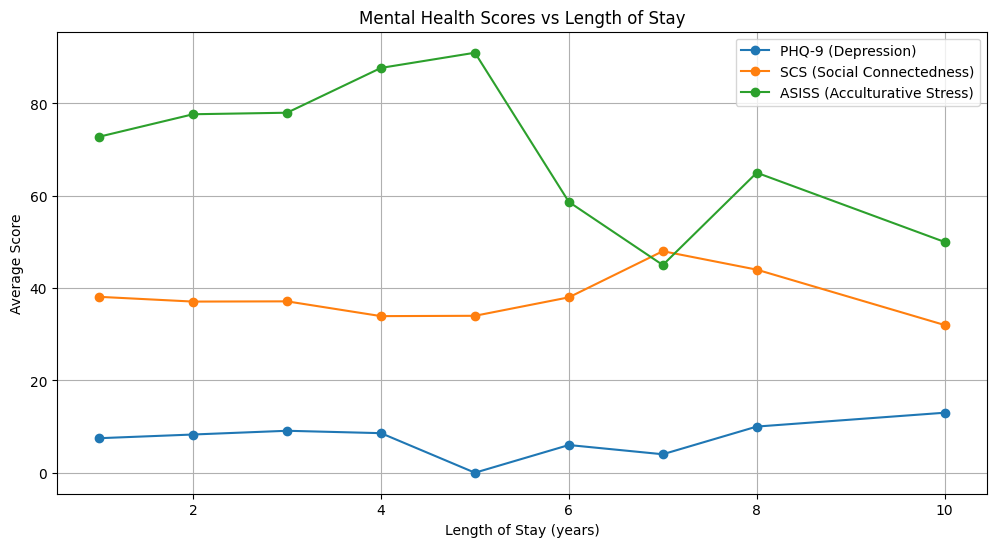

In [11]:
# Set up figure
plt.figure(figsize=(12, 6))

# Plot each test score
plt.plot(table1['stay'], table1['average_phq'], label='PHQ-9 (Depression)', marker='o')
plt.plot(table1['stay'], table1['average_scs'], label='SCS (Social Connectedness)', marker='o')
plt.plot(table1['stay'], table1['average_as'], label='ASISS (Acculturative Stress)', marker='o')

# Add labels and formatting
plt.xlabel("Length of Stay (years)")
plt.ylabel("Average Score")
plt.title("Mental Health Scores vs Length of Stay")
plt.legend()
plt.grid(True)
plt.show()

The graph above shows the average raw scores from three mental health assessments plotted against length of stay, but due to the different scoring ranges of each test (e.g., PHQ-9's max is 27 vs. ASISS scores reaching 90+), it's difficult to visually compare trends across them. To better assess relative changes and spot patterns on a comparable scale, it's useful to standardize the scores—this is what the next graph achieves by plotting z-scores instead.

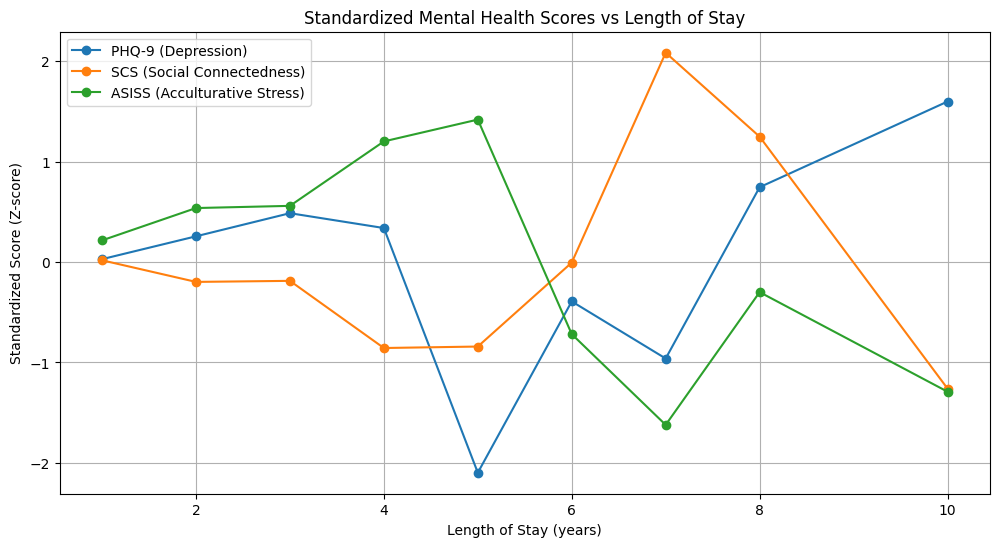

In [13]:
# Standardize mental health scores using z-score to enable comparison across tests
normalized = table1[['average_phq', 'average_scs', 'average_as']].apply(zscore)
normalized['stay'] = table1['stay']

# Plot standardized scores for each mental health test
plt.figure(figsize=(12, 6))
plt.plot(normalized['stay'], normalized['average_phq'], label='PHQ-9 (Depression)', marker='o')
plt.plot(normalized['stay'], normalized['average_scs'], label='SCS (Social Connectedness)', marker='o')
plt.plot(normalized['stay'], normalized['average_as'], label='ASISS (Acculturative Stress)', marker='o')

# Add labels and formatting
plt.xlabel("Length of Stay (years)")
plt.ylabel("Standardized Score (Z-score)")
plt.title("Standardized Mental Health Scores vs Length of Stay")
plt.legend()
plt.grid(True)
plt.show()

While depression scores (PHQ-9) show a clear upward trend with longer stays, the patterns for social connectedness (SCS) and acculturative stress (ASISS) are less consistent. SCS fluctuates, peaking around 7–8 years before declining, making it difficult to draw a definitive conclusion about its relationship with length of stay. Unfortunately, this lack of a clearly defined trend is likely due to the small amount of data available for international students whose stay is longer than 4 years. Any future analysis would require a larger dataset in order to reach accurate conclusions and assess correlation.

In [15]:
conn.close()